In [2]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import scipy as sp
import netCDF4 as nC4
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, add_timestamp
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeature


'/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc'

In [3]:
cs = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/1_2022-02-10.nc')
cp = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/b2nq_2022-02-10.nc')
ci = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/b2nr_2022-02-10.nc')

In [4]:
curr_storms = cs.squeeze().set_coords(['longitude','latitude','level'])

pi_storms = cp.squeeze().set_coords(['longitude','latitude','level'])

incr_storms = ci.squeeze().set_coords(['longitude','latitude','level'])
                                                                                                                             

If there are more than one level at a time for the isen_dataset(), it usualy cuase the run to crash as asymptope can't be reached (i.e, our pressure levels are too sparse to allow convergence, and this became an error).

Averaging between the --needs to be done in some other way aha

Okay! Now we can see that subplot() likes projection but subplots() do.

Can't really change the data type of t, unless the unit will be happily lost;
Must fix the coordinates first. Or always try to fix the coord
The output of isentrope analysis is always un hashable--so I can't just put all the results together to calculate a mean directly.
Calculating a mean can stil take I don't konw how long

Then there is the 'averaging on multiple pressure level' thingy
Well, we have 3 experiments, 50 members, so many lats and lons, 4 pressure levels that aren't completely parallel to the isentropes and we stil need to calculate the slope of isentrope.
That's gonna take a while.

No to mention all the isobars and things like that.


As another attempt--as suggested by chatgpt: use xarray instead of metpy

To be fair this will not make too much a difference because both methods use interpolation instead of searching/cataloguing on 100s lat times 100s lon times all the numbers

1. calculate pot temp
2. def isentropic levels
3. interpolate

In [60]:
timesteps = ['2022-02-14T18','2022-02-15T18','2022-02-16T18','2022-02-17T18','2022-02-18T18']
y_delta = 27.5*units.km
x_delta = 13.75*units.km
num_levs=5
ilev=np.array(np.linspace(320.,260.,num_levs)) #The function isentropic_interpolation would break at temperature below240.kelvin for curr,incr and supposedly pi as well.
plev=np.array([850.,700.,500.,250.])

incr_grad={}
curr_grad={}
pi_grad = {}

In [8]:
pi_msl = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc')
curr_msl = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc')
incr_msl = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc')

In [93]:
for ts in timesteps:
    mag_grad=np.zeros([163,289])
    t = pi_storms['t'].sel(time=ts).max(dim='number')
    z = pi_storms['z'].sel(time=ts).max(dim='number')
    for lev in ilev:
        isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, plev*units.hPa, t*units.kelvin, z)
        g_height = isen_pl[1][0]/9.80665
        t_grad=metpy.calc.gradient(g_height*units.km,deltas=(y_delta,x_delta))
        x = np.array(t_grad[0])
        y = np.array(t_grad[1])
        mag_grad+=(x**2+y**2)**(1/2)/num_levs
    pi_grad[ts]=mag_grad

for ts in timesteps:
    mag_grad=np.zeros([163,289])
    t = curr_storms['t'].sel(time=ts).max(dim='number')
    z = curr_storms['z'].sel(time=ts).max(dim='number')
    for lev in ilev:
        isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, plev*units.hPa, t*units.kelvin, z)
        g_height = isen_pl[1][0]/9.80665
        t_grad=metpy.calc.gradient(g_height*units.km,deltas=(y_delta,x_delta))
        x = np.array(t_grad[0])
        y = np.array(t_grad[1])
        mag_grad+=(x**2+y**2)**(1/2)/num_levs
    curr_grad[ts]=mag_grad



In [94]:
incr_lev = np.array([  10,   50,  100,  200,  250,  500,  700,  850,  925, 1000])
for ts in timesteps:
    mag_grad=np.zeros([163,289])
    t = incr_storms['t'].sel(time=ts).max(dim='number')
    z = incr_storms['z'].sel(time=ts).max(dim='number')
    '''isen_pl = mpcalc.isentropic_interpolation(295*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
    g_height = isen_pl[1][0]/9.80665
    t_grad=metpy.calc.gradient(g_height*units.km,deltas=(y_delta,x_delta))
    x = np.array(t_grad[0])
    y = np.array(t_grad[1])
    mag_grad+=(x**2+y**2)**(1/2)
    incr_grad[ts]=mag_grad'''

    for lev in [310.,305.,300.,295.]:
        isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
        g_height = isen_pl[1][0]/9.80665
        t_grad=metpy.calc.gradient(g_height*units.km,deltas=(y_delta,x_delta))
        x = np.array(t_grad[0])
        y = np.array(t_grad[1])
        mag_grad+=(x**2+y**2)**(1/2)/4
    incr_grad[ts]=mag_grad


/tmp/user/27783/ipykernel_999465/1024024294.py:15: UserWarning: Interpolation point out of data bounds encountered
  isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
/tmp/user/27783/ipykernel_999465/1024024294.py:15: UserWarning: Interpolation point out of data bounds encountered
  isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
/tmp/user/27783/ipykernel_999465/1024024294.py:15: UserWarning: Interpolation point out of data bounds encountered
  isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
/tmp/user/27783/ipykernel_999465/1024024294.py:15: UserWarning: Interpolation point out of data bounds encountered
  isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, incr_lev*units.hPa, t*units.kelvin, z)
/tmp/user/27783/ipykernel_999465/1024024294.py:15: UserWarning: Interpolation point out of data bounds encountered
  isen_pl = mpcalc.is

In [95]:
incr_grad

{'2022-02-14T18': array([[2.22841178, 2.03581791, 1.62050286, ..., 4.00132483, 4.02542629,
         3.74754936],
        [1.6011799 , 1.45132743, 1.41799167, ..., 2.50404284, 2.77052367,
         3.48884091],
        [0.91610787, 0.88769994, 0.816535  , ..., 0.66752247, 0.87313634,
         0.86865566],
        ...,
        [0.99890415, 0.97882689, 0.98424186, ..., 3.50452957, 3.15642816,
         3.53789472],
        [0.53370603, 0.59101151, 0.95823102, ..., 3.14932704, 2.83170037,
         2.6729642 ],
        [0.94699484, 1.07759544, 1.18544459, ..., 2.79313424, 2.6447416 ,
         2.63238355]]),
 '2022-02-15T18': array([[2.69970934, 3.02411436, 3.4665384 , ..., 3.78303789, 3.11717538,
         2.33323382],
        [2.42959801, 2.43178311, 2.58786263, ..., 4.66007439, 4.53824745,
         4.43195784],
        [1.87347758, 1.41873656, 1.15052237, ..., 4.71132668, 4.72750843,
         4.76858061],
        ...,
        [1.49644756, 1.08045203, 0.70208276, ..., 3.34866761, 3.89924475,


Argh, do I have to distinguish between the 

/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


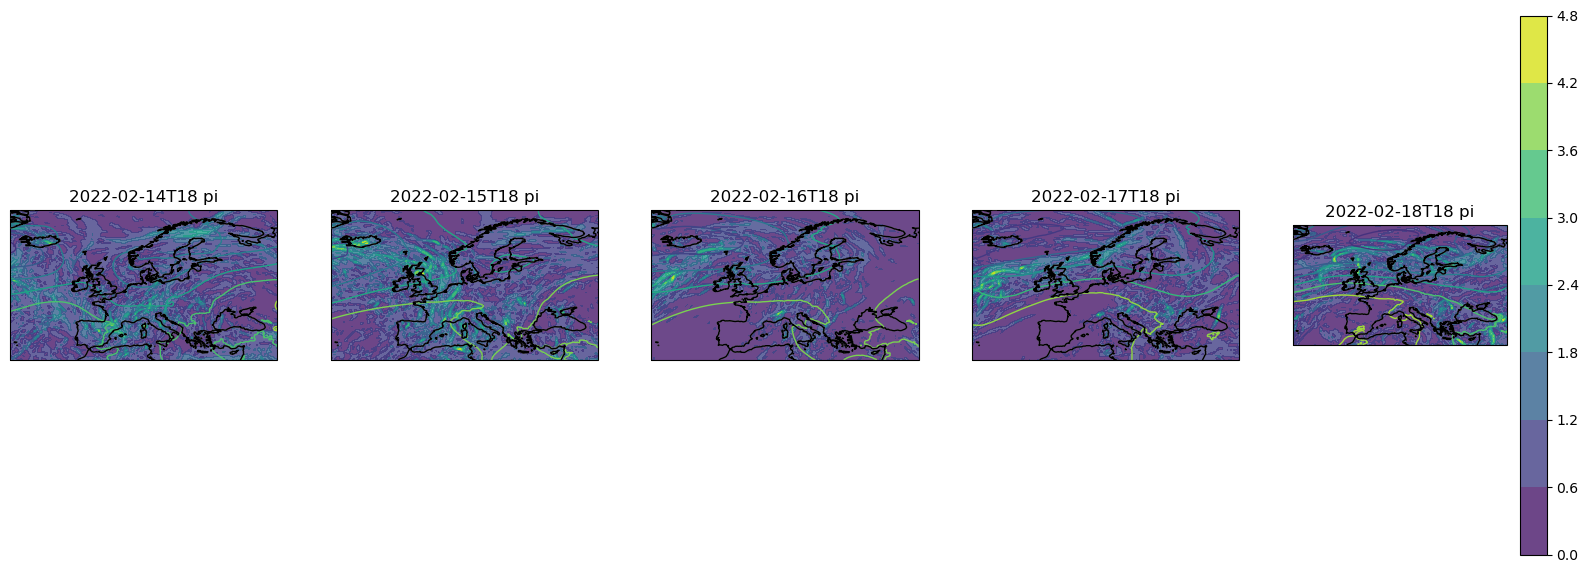

In [97]:
lev=np.linspace(1,3,10)
projection=ccrs.PlateCarree()
lon = pi_msl.longitude
lat = pi_msl.latitude
#original, when 4 isentropic surfaces, is (0,0.0014,8)
#To be very fair, since maybe only about 4 or at most 5 pressure levels can work here, I don't really think it will be particularly useful to choose more than
#5 levels. It will just be more interpolation--And yes you can see it dragged the entire slope down a bit, which I don't like.


fig = plt.figure(1, figsize=(20, 7))
for num,ts in enumerate(timesteps):
    ax = plt.subplot(1,5,num+1,projection=projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    msl = pi_msl.sel(time=ts).mean(dim='number').msl
    msl.plot.contour(linewidths=1)
    #this is planned for msl to track the storm 
    ci = ax.contourf(lon, lat, pi_grad[ts], 
    #levels=lev,
    alpha=0.8,cmap='viridis')
    ax.set_title(ts+' pi')
 
    
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'k', zorder = 14)
plt.colorbar(ci)



/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


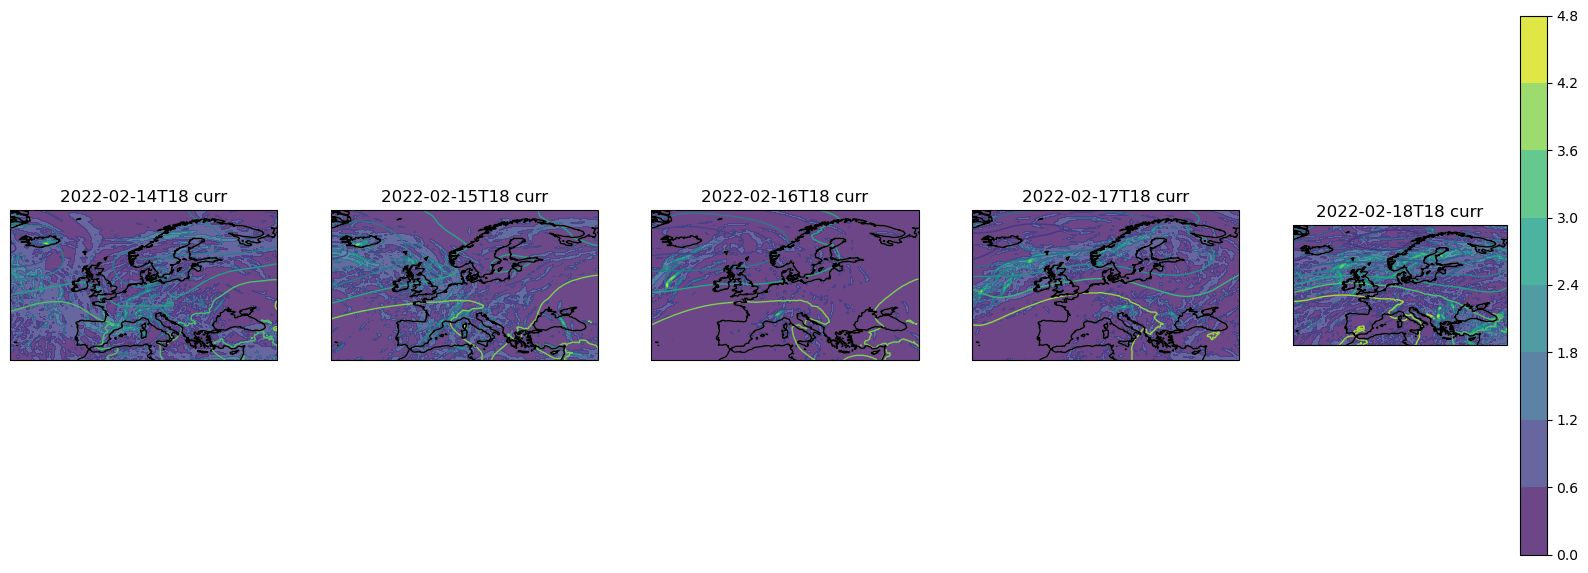

In [98]:
fig = plt.figure(1, figsize=(20, 7))
for num,ts in enumerate(timesteps):
    ax = plt.subplot(1,5,num+1,projection=projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    msl = pi_msl.sel(time=ts).mean(dim='number').msl
    msl.plot.contour(linewidths=1)
    ci = ax.contourf(lon, lat, curr_grad[ts], 
    #levels=lev,
    alpha=0.8,cmap='viridis')
    #this is planned for msl to track the storm 
    # cs = ax.contour()
    
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'k', zorder = 14)
    ax.set_title(ts+' curr')
plt.colorbar(ci)




/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


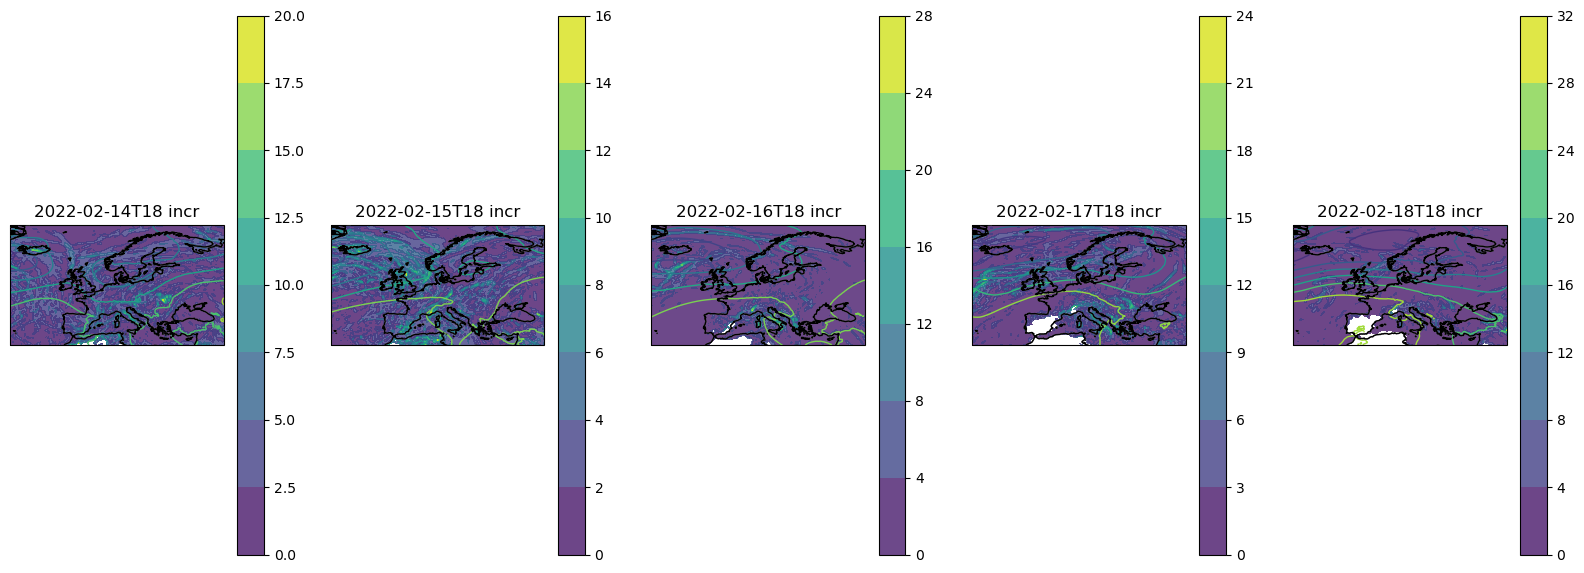

In [99]:
fig = plt.figure(1, figsize=(20, 7)) 
for num,ts in enumerate(timesteps):
    ax = plt.subplot(1,5,num+1,projection=projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

    msl = pi_msl.sel(time=ts).mean(dim='number').msl
    msl.plot.contour(linewidths=1)
    ci = ax.contourf(lon, lat, incr_grad[ts], 
    #levels = lev, 
    alpha=0.8,cmap='viridis')
    #this is planned for msl to track the storm 
    # cs = ax.contour()
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'k', zorder = 14)
    ax.set_title(ts+' incr')
    plt.colorbar(ci)



/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'level'
  result = super().contourf(*args, **kwargs)


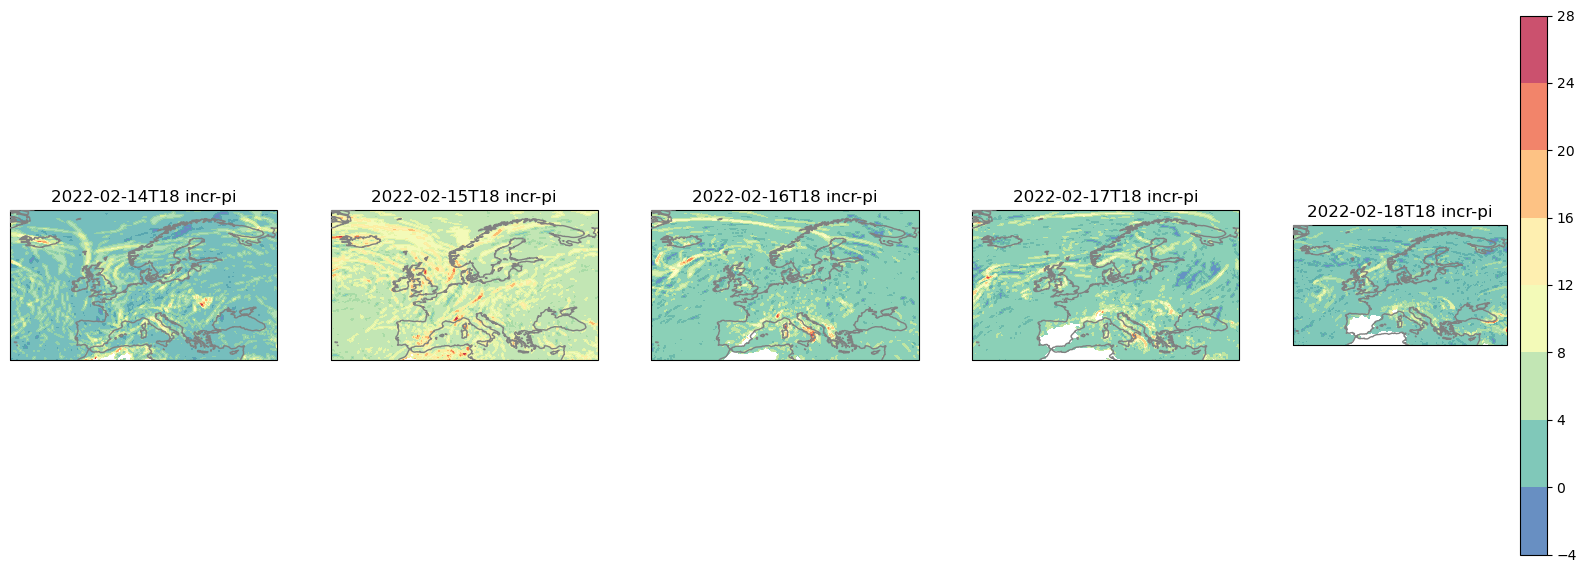

In [100]:
d_lev = np.linspace(-5,5,8)


fig = plt.figure(1, figsize=(20, 7))
for num,ts in enumerate(timesteps):
    ax = plt.subplot(1,5,num+1,projection=projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    ci = ax.contourf(lon, lat, incr_grad[ts]-pi_grad[ts],level=d_lev, alpha=0.8,cmap='Spectral_r')
    #this is planned for msl to track the storm 
    ax.set_title(ts+' incr-pi')

plt.colorbar(ci)

Loading in era5 data to at least confirm the background state

In [101]:
era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/pl/2022.nc')

In [105]:
era5_2022

<xarray.Dataset>
Dimensions:    (longitude: 289, latitude: 163, level: 3, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * level      (level) int32 500 700 850
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-02-28T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-23 11:52:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [104]:
era_plev = np.array([500, 700, 850])
era_time = era5_2022.time
lon

grad = np.zeros([289,163])

for ts in era_time:
    t = era5_2022['t'].sel(time=ts)
    z = era5_2022['z'].sel(time=ts)
    for lev in ilev:
        isen_pl = mpcalc.isentropic_interpolation(lev*units.kelvin, era_lev*units.hPa, t*units.kelvin, z)
        g_height = isen_pl[1][0]/9.80665
        t_grad=metpy.calc.gradient(g_height*units.km,deltas=(y_delta,x_delta))
        x = np.array(t_grad[0])
        y = np.array(t_grad[1])
        isenlope = (x**2+y**2)**(1/2)
        grad += isenlope/1416/3

KeyError: 't'

oh no, oh no, I forgot to download the data t